## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json
import time
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import PowerTransform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats.stats import pearsonr, spearmanr

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print(tf.__version__)
# from tensorflow import keras

from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.regularizers import l1
from keras.constraints import unit_norm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from collections import OrderedDict
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import mean_squared_error
from math import log
import category_encoders as ce
import tensorflow.keras.backend as K
print("GPU Available: ", tf.test.is_gpu_available())


import shap

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


## Helper Methods

In [2]:
output_column = 'LE_bowen_corr(mm)'
def read_data():
        file_path = "/Users/saraawad/Desktop/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
        df = pd.read_csv(file_path, delimiter=',')

        columnsToDrop = ['Date', 'Year', 'Month', 'Day', 'Site Id_1', 'Site Id_2', 'Site Id_3',
                        'Site Id_4', 'Site Id_5', 'Site Id_6','Vegetation', 'Latitude', 'Longitude', 'Climate',
                        'G','G-1','G-2','G-3','G-4','G-5',
                        'Climate_1', 'Climate_2', 'Climate_3',
                        'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                        'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                        'Longitude_5', 'Longitude_6',
                        'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                        'H_bowen_corr-5', 'C_BOWENS',
                        'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                        'LE', 'LE_bowen_corr',
                        'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                        'Elevation(m)_5', 'Elevation(m)_6',
                        'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']

        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        df = df[df[output_column].between(1, 15)]

        #Generate 5 lags
        lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
        df = generate_lags(df, lagsForColumns)
        df.dropna(inplace=True)

        #Binary Encode Site Id
        df = binary_encode_column(df, "Site Id")

        #Drop columns
        df.drop(columns=['Site Id_0'], inplace=True)
        return df

def binary_encode_column(df, columnToEncode):
        encoder = ce.BinaryEncoder(cols=[columnToEncode])
        df_encoder = encoder.fit_transform(df[columnToEncode])
        df = pd.concat([df, df_encoder], axis=1)
        return df

def generate_lags_for(df, column, lags_count): 
            for i in range(lags_count):
                lag_name = column + "-" + str(i + 1)
                df[lag_name] = df[column].shift(i + 1)
            return df

def generate_lags(df, lagsForColumns):
        for k in range(len(lagsForColumns)):
            col = lagsForColumns[k]
            if col in df.columns:
                df = generate_lags_for(df, col, 5)
        return df
    
    
def split_train_test(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, Y_train, X_test, Y_test

In [3]:
df = read_data()
columns = ['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4','Site Id_5',
        'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
       'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5', 'LE_bowen_corr(mm)']
df = df[columns]


#split into train and test according to special split
X_train, Y_train, X_test, Y_test = split_train_test(df, 0.8, 0.2)

columnsToDrop = ['Site Id']
X_train = X_train.drop(columnsToDrop, axis = 1)
X_test = X_test.drop(columnsToDrop, axis = 1)
print("columns", X_train.columns)

print(np.array(df['LE_bowen_corr(mm)']).mean())
n_input = X_train.shape[1]
print(n_input)

Number of sites: 26
columns Index(['Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5'],
      dtype='object')
3.7471547625276562
48


# SHAP

Train a model

In [4]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tf.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    return model

create_model().summary

param_grid = {
              'first_neuron':[64],
              'activation' : ['softmax'],
              'init': ['uniform'],
              'dropout_rate' : [0.4],
              'dense_layer_sizes' : [2],
              'optimizer' : ['Adam'],
              'loss': ['mean_squared_error'],
              'epochs':[300],
              'batch_size':[64]
             }



model = create_model()
history = model.fit(X_train_scaled,
                    Y_train,
                    epochs=300,
                   verbose=1,
                   callbacks=[])

Epoch 1/300
273/273 [==============================] - 0s 960us/step - loss: 2.8914 - mse: 2.8900 - mae: 1.2211 - accuracy: 0.0000e+00 - mape: 38.5260
Epoch 2/300
273/273 [==============================] - 0s 1ms/step - loss: 1.8864 - mse: 1.8847 - mae: 1.0089 - accuracy: 0.0000e+00 - mape: 33.1623
Epoch 3/300
273/273 [==============================] - 0s 850us/step - loss: 1.7207 - mse: 1.7188 - mae: 0.9632 - accuracy: 0.0000e+00 - mape: 31.7815
Epoch 4/300
273/273 [==============================] - 0s 903us/step - loss: 1.5990 - mse: 1.5969 - mae: 0.9226 - accuracy: 0.0000e+00 - mape: 30.4903
Epoch 5/300
273/273 [==============================] - 0s 974us/step - loss: 1.5859 - mse: 1.5835 - mae: 0.9204 - accuracy: 0.0000e+00 - mape: 30.4009
Epoch 6/300
273/273 [==============================] - 0s 925us/step - loss: 1.5183 - mse: 1.5156 - mae: 0.8991 - accuracy: 0.0000e+00 - mape: 29.7967
Epoch 7/300
273/273 [==============================] - 0s 901us/step - loss: 1.4516 - mse: 1.448

In [5]:
Y_predict = model.predict(X_test_scaled)

def error_metrics(y_test, y_pred, nb_columns, nb_param):
    n = len(y_test)
    #convert to float for it to work for AIC and BIC data should all be of the same format i.e float not mix of types
    y_test_f =  [float(item) for item in y_test.values]
    y_predict_f =  [float(item) for item in y_pred]
    test_scores = {}
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test_f, y_predict_f)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    re = (mse_score / np.mean(y_pred)) * 100
    accuracy = 100 - np.mean(mape_score)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    r2 = str(round(r2_Score, 2))
    adjusted_r2 = str(round(adjusted_r2, 2))
    mae = str(round(mae_score, 2))
    mse = str(round(mse_score, 2))
    rmse = str(round(rmse_score, 2))
    re = str(round(re, 2))
    spearman = str(round(spearman_corr, 2))
    mape = str(round(mape_score, 2)) + "%"
    accuracy = str(round(accuracy, 2)) + "%"
    
    nmi = 1
    def calculate_aic(n, mse, num_params):
        aic = n * log(mse) + 2 * num_params
        return aic

    def calculate_bic(n, mse, num_params):
        bic = n * log(mse) + num_params * log(n)
        return bic

    aic = str(round(calculate_aic(len(y_test), mse_score, nb_param), 2))
    bic = str(round(calculate_bic(len(y_test), mse_score, nb_param), 2))

    test_scores["average output"] =  str(y_test.mean())
    test_scores["R2"] = r2
    test_scores["Adjusted R2"] = adjusted_r2
    test_scores["MAE"] = mae
    test_scores["MSE"] = mse
    test_scores["RMSE"] = rmse
    test_scores["Relative Error"] = re
    test_scores["Spearman"] = spearman
    test_scores["MAPE"] = mape
    test_scores["Accuracy"] = accuracy
    test_scores["Information Mutal Normalised"] = nmi
    test_scores["AIC"] = aic
    test_scores["BIC"] = bic
    return test_scores

nb_param = np.sum([K.count_params(w) for w in model.trainable_weights])
error_metrics(Y_test, Y_predict, n_input, nb_param)

{'average output': 'LE_bowen_corr(mm)    3.573872\ndtype: float64',
 'R2': '0.53',
 'Adjusted R2': '0.52',
 'MAE': '0.96',
 'MSE': '1.71',
 'RMSE': '1.31',
 'Relative Error': '46.3',
 'Spearman': '0.75',
 'MAPE': '34.02%',
 'Accuracy': '65.98%',
 'Information Mutal Normalised': 1,
 'AIC': '8015.13',
 'BIC': '27490.97'}

Get Shap values

In [6]:
shap.initjs()
shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough

# create an instance of the DeepSHAP which is called DeepExplainer
# explainer_shap = shap.DeepExplainer(model=model, data = tf.convert_to_tensor(X_train.iloc[:100, :]).numpy())
explainer_shap = shap.DeepExplainer(model=model, data = tf.convert_to_tensor(X_train_scaled).numpy())


# Fit the explainer on a subset of the data (you can try all but then gets slower)
shap_values = explainer_shap.shap_values(np.array(X_test_scaled))
np.array(shap_values).shape

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


(1, 2193, 48)

In [7]:
X_test.columns

Index(['Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5'],
      dtype='object')

OR the Categorical Columns

In [8]:
X_test_new = X_test
X_test_new['Month_encoded'] = np.logical_or(X_test_new['Month_1'], X_test_new['Month_2'])
X_test_new['Month_encoded'] = np.logical_or(X_test_new['Month_encoded'], X_test_new['Month_3'])
X_test_new['Month_encoded'] = np.logical_or(X_test_new['Month_encoded'], X_test_new['Month_4'])

X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site Id_1'], X_test_new['Site Id_2'])
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_encoded'], X_test_new['Site Id_3'])
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_encoded'], X_test_new['Site Id_4'])
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_encoded'], X_test_new['Site Id_5'])

X_test_new['Vegt_encoded'] = np.logical_or(X_test_new['Vegetation_1'], X_test_new['Vegetation_2'])
X_test_new['Vegt_encoded'] = np.logical_or(X_test_new['Vegt_encoded'], X_test_new['Vegetation_3'])

X_test_new = X_test_new.drop(['Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5'
                              , 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
                'Vegetation_2', 'Vegetation_3'], axis = 1)

X_test_new['Site_encoded'] = X_test_new['Site_encoded'].astype(int)
X_test_new['Vegt_encoded'] = X_test_new['Vegt_encoded'].astype(int)
X_test_new['Month_encoded'] = X_test_new['Month_encoded'].astype(int)

In [9]:
cols = ['Site_encoded', 'Month_encoded', 'Vegt_encoded', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5']

X_test_new = X_test_new[cols]

In [10]:
X_test_new.shape

(2193, 39)

In [11]:
X_test.columns

Index(['Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5', 'Month_encoded', 'Site_encoded', 'Vegt_encoded'],
      dtype='object')

In [12]:
X_test.shape

(2193, 51)

Sum up SHAP values

In [13]:
shap_values_new = np.empty(shape=[X_test_new.shape[0], X_test_new.shape[1]])
shap_values = np.array(shap_values)

shap_values_new[:,0] = shap_values[0, :,0] +  shap_values[0, :,1] + shap_values[0, :,2] +  shap_values[0, :,3]
shap_values_new[:,1] = shap_values[0, :,4] +  shap_values[0, :,5] + shap_values[0, :,6]
shap_values_new[:,2] = shap_values[0, :,43] +  shap_values[0, :,44] + shap_values[0, :,45] + shap_values[0, :,46] +  + shap_values[0, :,47]

In [14]:
print("shap_values", shap_values.shape)
print("shap_values_new", shap_values_new.shape)

shap_values (1, 2193, 48)
shap_values_new (2193, 39)


In [15]:
i = 3
j = 12
while i < shap_values_new.shape[1]:
    print(i)
    shap_values_new[:,i] = shap_values[0,:,j] # j is out of bound check with Yasmine
    i = i+1
    j = j+1

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


# Getting Accurate Predictions

In [16]:
def get_accurate_prediction_score(y_test, y_pred):
    ratio = np.abs(y_test - y_pred) / y_test
    return ratio


#extract indices with error % not more than 10%
index = []
for i in range(len(Y_test)):
    score = get_accurate_prediction_score(np.array(Y_test)[i], np.array(Y_predict)[i])
    print(score)
    if score <= 0.1:
        index.append(i)

[0.14237231]
[0.14044193]
[0.17177801]
[0.19750456]
[0.4957111]
[0.275198]
[0.19657127]
[0.40014]
[0.78841744]
[1.64926794]
[1.08212603]
[0.43387241]
[0.17502536]
[0.49133231]
[0.20380893]
[0.08290616]
[0.06478242]
[0.28764779]
[0.16265662]
[0.32055042]
[0.3906526]
[0.55442112]
[0.50765849]
[0.43306814]
[0.0888414]
[0.28105038]
[0.00245613]
[0.60783426]
[0.17151302]
[0.01204906]
[0.0814331]
[0.41578865]
[0.06419348]
[0.05030448]
[0.16272622]
[0.21373075]
[0.1231909]
[0.04522118]
[0.39282954]
[0.31729543]
[0.28103585]
[0.48646342]
[0.15099996]
[0.11362068]
[0.35105006]
[0.04408772]
[0.30241363]
[0.6144973]
[0.58608428]
[0.5053812]
[0.66823899]
[0.21012078]
[0.36862439]
[0.24894817]
[0.03127232]
[0.1997671]
[0.32466442]
[0.19855565]
[0.36755431]
[0.06015462]
[0.09868044]
[0.5784249]
[0.30232382]
[0.0935825]
[0.32376703]
[0.23395035]
[0.01846676]
[0.06645513]
[0.05662102]
[0.04989502]
[0.18309081]
[0.22504145]
[0.25616855]
[0.27646658]
[0.07010798]
[0.07721177]
[0.06478159]
[0.27056002]
[

In [17]:
len(index)

507

In [18]:
#subsetting dataset to get only the accurate predictions
X_test_accurate = X_test_new
X_test_accurate = X_test_accurate[X_test_accurate.index.isin(index)]

In [19]:
shap_values_accurate = shap_values_new
shap_values_accurate = shap_values_accurate[index]
len(shap_values_accurate)

507

# Extracting Rare Values

In [20]:
X_test_rare = pd.DataFrame()
shap_rare = []
for i in range(len(X_test_new)):
    X_test_i = X_test_new.iloc[i,:]
    if(Y_test.iloc[i,:][output_column] > 4):
        X_test_rare = X_test_rare.append(X_test_i)
        shap_rare.append(shap_values_new[i])
        
X_test_rare

EEflux Albedo  EEflux Albedo-1  EEflux Albedo-2  EEflux Albedo-3  \
14            0.121            0.119            0.119            0.104   
21            0.151            0.154            0.148            0.123   
28            0.152            0.150            0.146            0.146   
29            0.153            0.152            0.150            0.146   
30            0.153            0.153            0.152            0.150   
...             ...              ...              ...              ...   
2163          0.192            0.191            0.189            0.189   
2164          0.192            0.192            0.191            0.189   
2166          0.191            0.191            0.192            0.192   
2189          0.042            0.042            0.042            0.044   
2192          0.043            0.042            0.042            0.042   

      EEflux Albedo-4  EEflux Albedo-5  EEflux LST  EEflux LST-1  \
14              0.096            0.096      299.54        292.06   
21              0.123            0.121      288.38        290.16   
28              0.146            0.151      303.92        301.84   
29              0.146            0.146      302.42        303.92   
30              0.146            0.146      302.24        302.42   
...               ...              ...         ...           ...   
2163            0.189            0.189      305.30        304.62   
2164            0.189            0.189      305.04        305.30   
2166            0.191            0.189      304.58        303.84   
2189            0.044            0.050      283.26        285.86   
2192            0.042            0.042      282.66        285.84   

      EEflux LST-2  EEflux LST-3  ...       TA-3       TA-4       TA-5  \
14          289.86        291.30  ...  10.017958  11.702526   9.581022   
21          299.04        287.40  ...   8.810812  12.481705  10.947979   
28          293.40        286.16  ...   9.663457  11.035907  12.225659   
29          301.84        293.40  ...  10.230935   9.663457  11.035907   
30          303.92        301.84  ...  24.364000  10.230935   9.663457   
...            ...           ...  ...        ...        ...        ...   
2163        303.50        301.80  ...  19.627111  19.009167  20.833333   
2164        304.62        303.50  ...  18.408261  19.627111  19.009167   
2166        305.04        305.30  ...  20.966739  22.277805  18.408261   
2189        274.02        286.78  ...   9.916758   9.526565  11.172950   
2192        283.08        283.26  ...   6.945208   8.988729   8.147104   

      Vegt_encoded        WS      WS-1      WS-2      WS-3      WS-4      WS-5  
14             1.0  3.392149  3.800021  2.028814  1.770396  1.784763  2.215130  
21             1.0  1.487524  5.244729  3.001722  3.710562  2.637341  4.368292  
28             1.0  1.064872  0.833125  0.763032  2.172761  3.484791  1.597951  
29             1.0  1.241444  1.064872  0.833125  0.763032  2.172761  3.484791  
30             1.0  1.695500  1.241444  1.064872  0.833125  0.763032  2.172761  
...            ...       ...       ...       ...       ...       ...       ...  
2163           1.0  1.622298  1.329216  1.967802  1.744629  2.492239  1.589209  
2164           1.0  1.588097  1.622298  1.329216  1.967802  1.744629  2.492239  
2166           1.0  2.618957  1.611574  1.588097  1.622298  1.329216  1.967802  
2189           1.0  5.318896  2.504060  1.367879  1.168626  2.851230  0.983358  
2192           1.0  6.972690  1.171712  1.042243  5.318896  2.504060  1.367879  

[816 rows x 39 columns]

# SHAP Plots

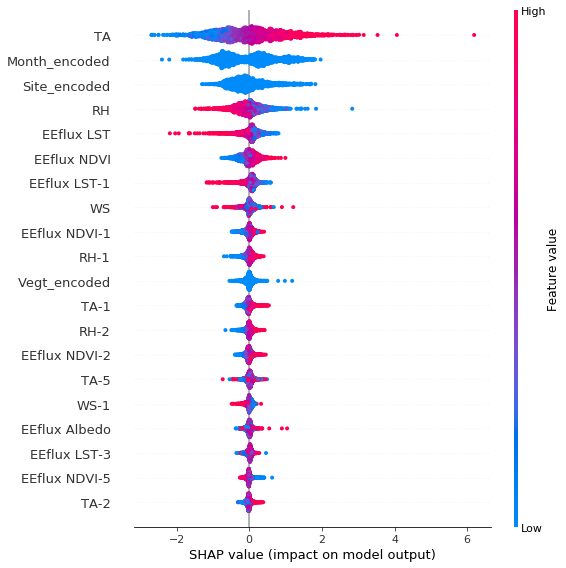

In [21]:
## SHAP plot for loc trees
shap.summary_plot(shap_values_new, X_test_new, feature_names=X_test_new.columns)

Contributon of each input feature to the output as in low or high impact

High RH values => output LE low

High LST values => output LE low

High TA values => output LE low

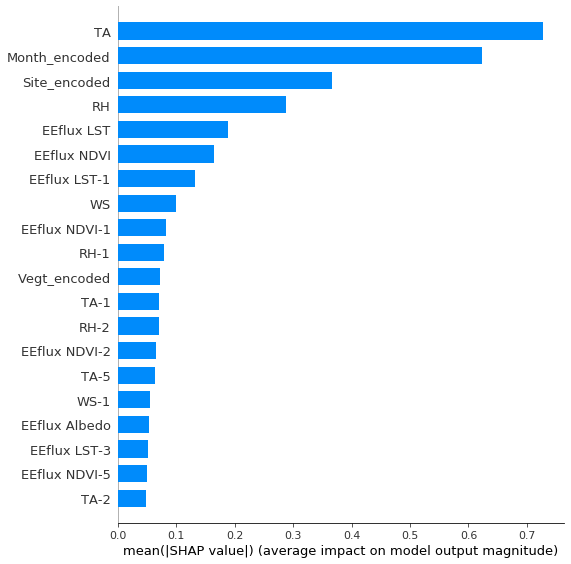

In [22]:
shap.summary_plot(shap_values_new, X_test_new, plot_type='bar')

SHAP Force Plot on Rare Values in Testing Data

In [23]:
X_test_rare = pd.DataFrame()
shap_rare = []
for i in range(len(X_test_new)):
    X_test_i = X_test_new.iloc[i,:]
    if(Y_test.iloc[i,:][output_column] > 4):
        X_test_rare = X_test_rare.append(X_test_i)
        shap_rare.append(shap_values_new[i])
        
X_test_rare

EEflux Albedo  EEflux Albedo-1  EEflux Albedo-2  EEflux Albedo-3  \
14            0.121            0.119            0.119            0.104   
21            0.151            0.154            0.148            0.123   
28            0.152            0.150            0.146            0.146   
29            0.153            0.152            0.150            0.146   
30            0.153            0.153            0.152            0.150   
...             ...              ...              ...              ...   
2163          0.192            0.191            0.189            0.189   
2164          0.192            0.192            0.191            0.189   
2166          0.191            0.191            0.192            0.192   
2189          0.042            0.042            0.042            0.044   
2192          0.043            0.042            0.042            0.042   

      EEflux Albedo-4  EEflux Albedo-5  EEflux LST  EEflux LST-1  \
14              0.096            0.096      299.54        292.06   
21              0.123            0.121      288.38        290.16   
28              0.146            0.151      303.92        301.84   
29              0.146            0.146      302.42        303.92   
30              0.146            0.146      302.24        302.42   
...               ...              ...         ...           ...   
2163            0.189            0.189      305.30        304.62   
2164            0.189            0.189      305.04        305.30   
2166            0.191            0.189      304.58        303.84   
2189            0.044            0.050      283.26        285.86   
2192            0.042            0.042      282.66        285.84   

      EEflux LST-2  EEflux LST-3  ...       TA-3       TA-4       TA-5  \
14          289.86        291.30  ...  10.017958  11.702526   9.581022   
21          299.04        287.40  ...   8.810812  12.481705  10.947979   
28          293.40        286.16  ...   9.663457  11.035907  12.225659   
29          301.84        293.40  ...  10.230935   9.663457  11.035907   
30          303.92        301.84  ...  24.364000  10.230935   9.663457   
...            ...           ...  ...        ...        ...        ...   
2163        303.50        301.80  ...  19.627111  19.009167  20.833333   
2164        304.62        303.50  ...  18.408261  19.627111  19.009167   
2166        305.04        305.30  ...  20.966739  22.277805  18.408261   
2189        274.02        286.78  ...   9.916758   9.526565  11.172950   
2192        283.08        283.26  ...   6.945208   8.988729   8.147104   

      Vegt_encoded        WS      WS-1      WS-2      WS-3      WS-4      WS-5  
14             1.0  3.392149  3.800021  2.028814  1.770396  1.784763  2.215130  
21             1.0  1.487524  5.244729  3.001722  3.710562  2.637341  4.368292  
28             1.0  1.064872  0.833125  0.763032  2.172761  3.484791  1.597951  
29             1.0  1.241444  1.064872  0.833125  0.763032  2.172761  3.484791  
30             1.0  1.695500  1.241444  1.064872  0.833125  0.763032  2.172761  
...            ...       ...       ...       ...       ...       ...       ...  
2163           1.0  1.622298  1.329216  1.967802  1.744629  2.492239  1.589209  
2164           1.0  1.588097  1.622298  1.329216  1.967802  1.744629  2.492239  
2166           1.0  2.618957  1.611574  1.588097  1.622298  1.329216  1.967802  
2189           1.0  5.318896  2.504060  1.367879  1.168626  2.851230  0.983358  
2192           1.0  6.972690  1.171712  1.042243  5.318896  2.504060  1.367879  

[816 rows x 39 columns]

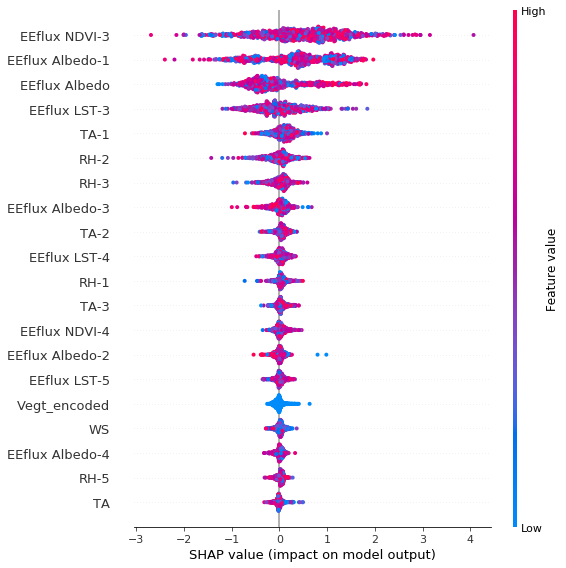

In [24]:
shap.summary_plot(np.array(shap_rare), X_test_rare, feature_names=X_test_rare.columns)

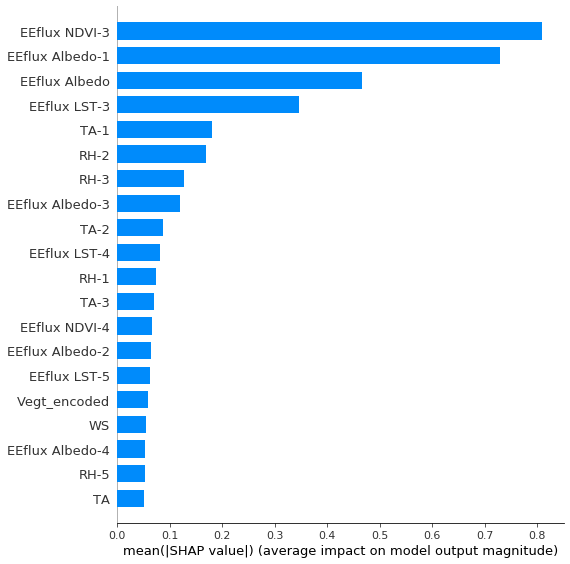

In [25]:
shap.summary_plot(np.array(shap_rare), X_test_rare, plot_type='bar')

SHAP Force Plot on Regular Values in Testing Data

In [26]:
X_test_notrare = pd.DataFrame()
shap_notrare = []
for i in range(len(X_test_new)):
    X_test_i = X_test_new.iloc[i,:]
    if(Y_test.iloc[i,:][output_column] < 5):
        X_test_notrare = X_test_notrare.append(X_test_i)
        shap_notrare.append(shap_values_new[i])
        
np.array(shap_notrare).shape

(1723, 39)

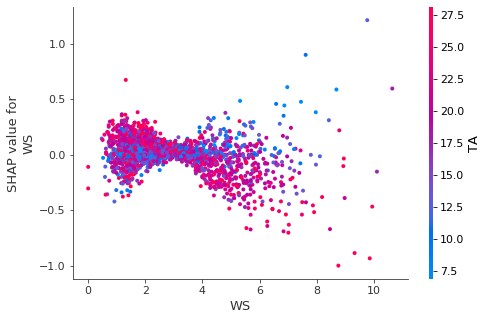

In [27]:
shap.dependence_plot('WS', np.array(shap_values_new), X_test_new)

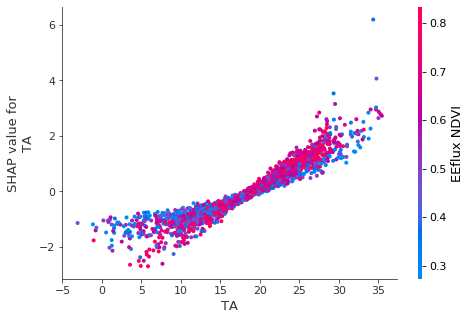

In [28]:
shap.dependence_plot('TA', np.array(shap_values_new), X_test_new)

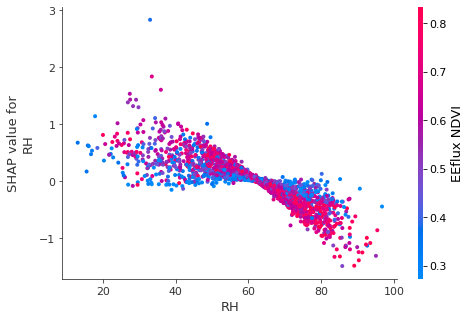

In [29]:
shap.dependence_plot('RH', np.array(shap_values_new), X_test_new)

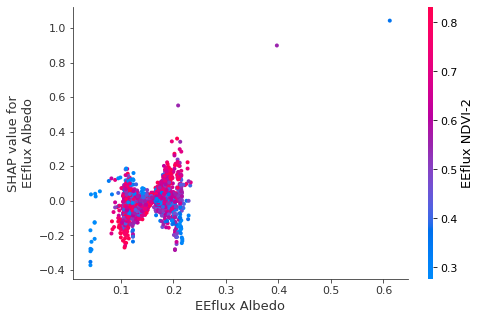

In [30]:
shap.dependence_plot('EEflux Albedo', np.array(shap_values_new), X_test_new)

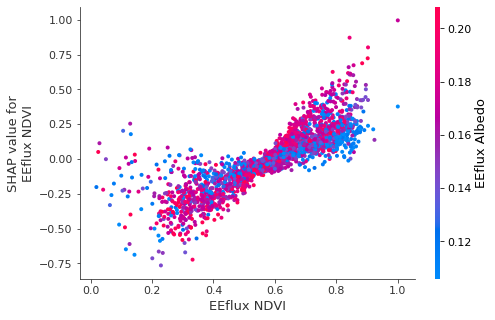

In [31]:
shap.dependence_plot('EEflux NDVI',np.array(shap_values_new), X_test_new)

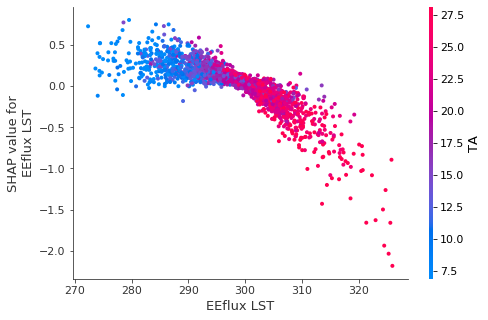

In [32]:
shap.dependence_plot('EEflux LST',np.array(shap_values_new), X_test_new)

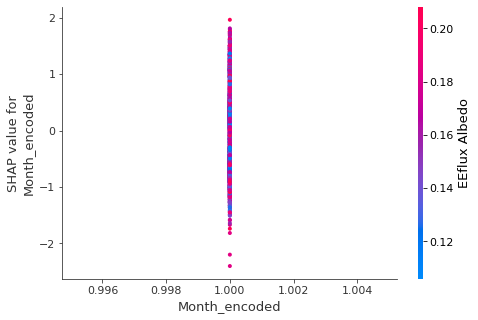

In [33]:
shap.dependence_plot('Month_encoded',np.array(shap_values_new), X_test_new)

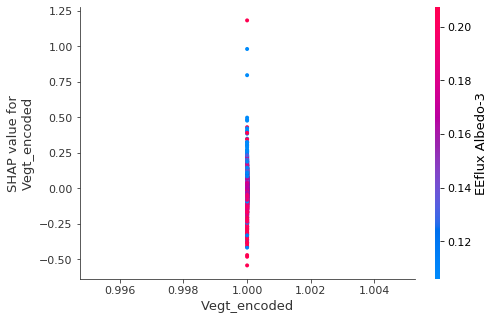

In [34]:
shap.dependence_plot('Vegt_encoded',np.array(shap_values_new), X_test_new)

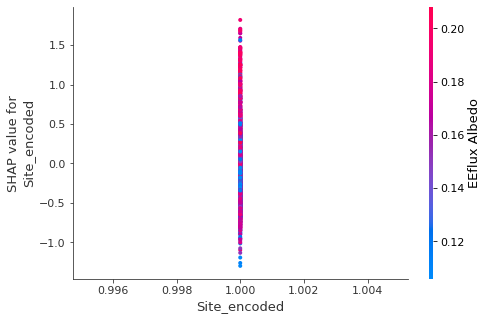

In [35]:
shap.dependence_plot('Site_encoded',np.array(shap_values_new), X_test_new)

On Rare

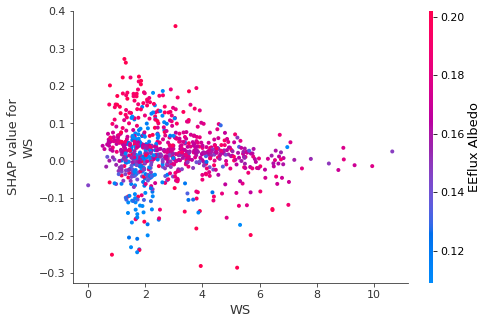

In [36]:
shap.dependence_plot('WS', np.array(shap_rare), X_test_rare)

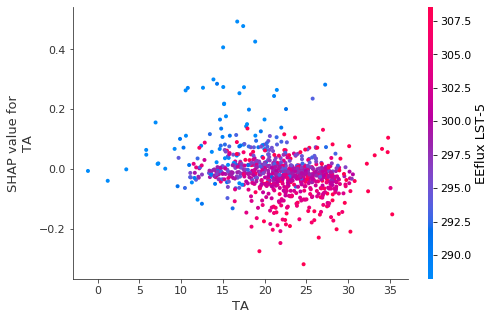

In [37]:
shap.dependence_plot('TA', np.array(shap_rare), X_test_rare)

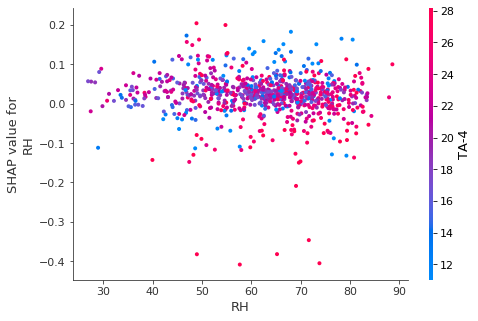

In [38]:
shap.dependence_plot('RH', np.array(shap_rare), X_test_rare)

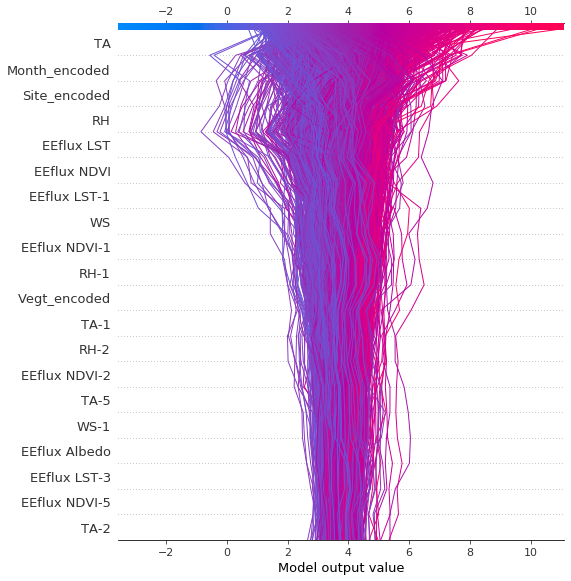

In [39]:
shap.decision_plot(explainer_shap.expected_value.numpy(),
                   np.array(shap_values_new),
                   np.array(X_test_new),
                   feature_names=list(X_test_new.columns),
                  ignore_warnings=True)

Decision Plot
Talk about when adding more features and color indications

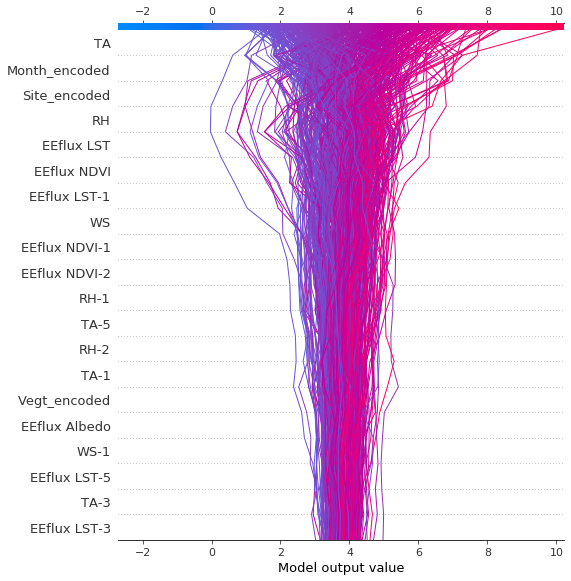

In [45]:
shap.decision_plot(explainer_shap.expected_value.numpy(),
                   np.array(shap_values_accurate),
                   np.array(X_test_accurate),
                   feature_names=list(X_test_new.columns))

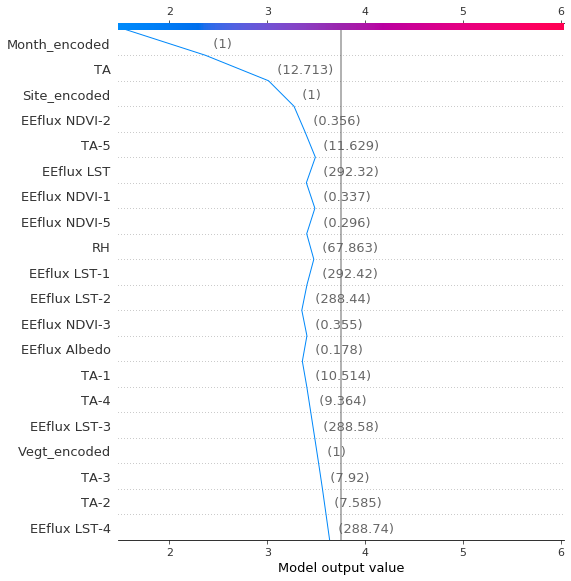

In [41]:
shap.decision_plot(explainer_shap.expected_value.numpy(),
                   np.array(shap_values_new)[34,:],
                   np.array(X_test_new)[34,:],
                   feature_names=list(X_test_new.columns))

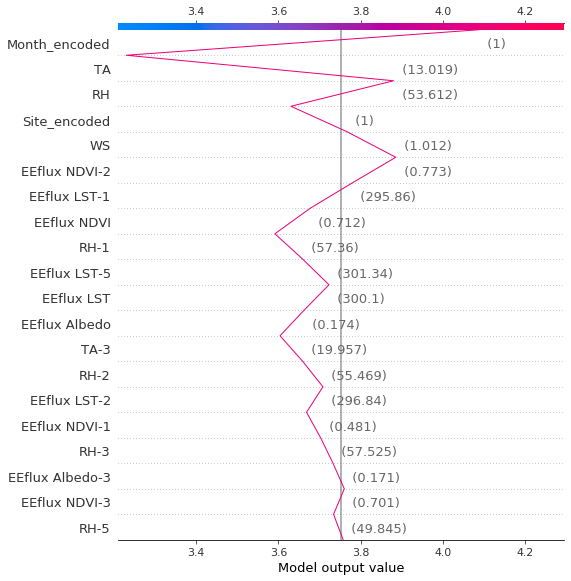

In [42]:
shap.decision_plot(explainer_shap.expected_value.numpy(),
                   np.array(shap_values_accurate)[34,:],
                   np.array(X_test_accurate)[34,:],
                   feature_names=list(X_test_new.columns))

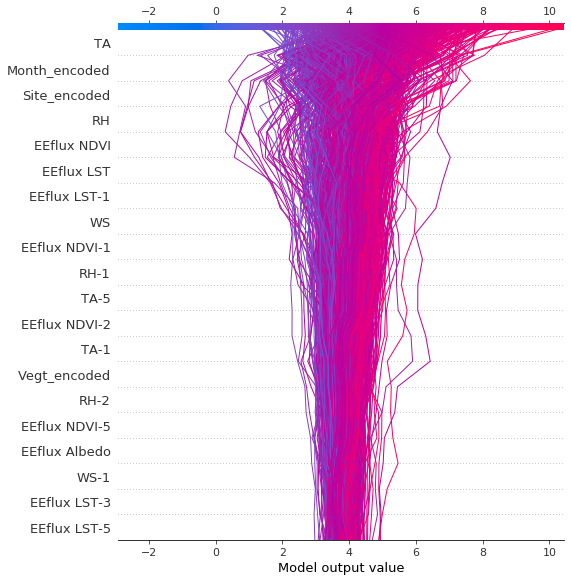

In [43]:
shap.decision_plot(explainer_shap.expected_value.numpy(),
                   np.array(shap_rare),
                   np.array(X_test_rare),
                   feature_names=list(X_test_new.columns))

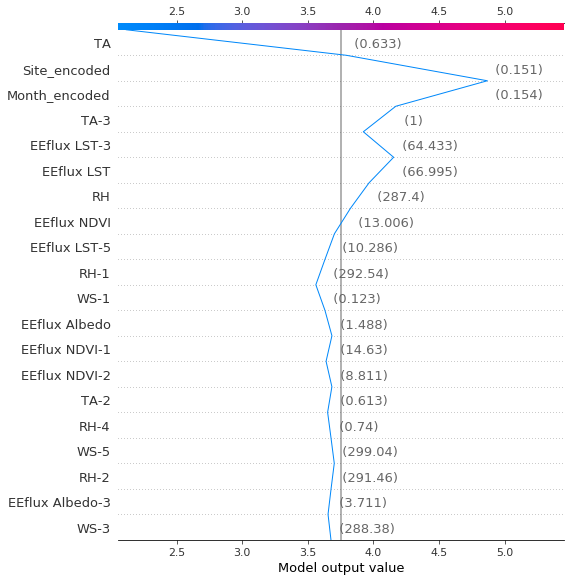

In [44]:
shap.decision_plot(explainer_shap.expected_value.numpy(),
                   np.array(shap_rare)[1,:],
                   np.array(X_test_rare)[1,:],
                   feature_names=list(X_test_new.columns),
                   link = 'identity')